## Image Segmentation with fastai

source: https://walkwithfastai.com/Segmentation


In [1]:
from fastai.vision.all import *

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [2]:
batch_size = 4

In [3]:
path = untar_data(URLs.CAMVID)


In [4]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [5]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [6]:
path_im = path/'images'
path_lbl = path/'labels'

In [7]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

<AxesSubplot:>

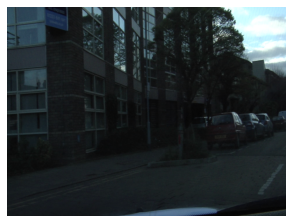

In [8]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [9]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

<AxesSubplot:>

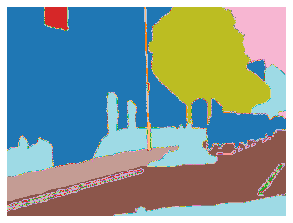

In [10]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [11]:
tensor(msk)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [17, 17, 17,  ..., 30, 30, 30],
        [17, 17, 17,  ..., 30, 30, 30],
        [17, 17, 17,  ..., 30, 30, 30]], dtype=torch.uint8)

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [14]:
sz = msk.shape; sz

(720, 960)

In [15]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [16]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])


In [17]:
dls = camvid.dataloaders(path/'images', bs=batch_size)

/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered interna

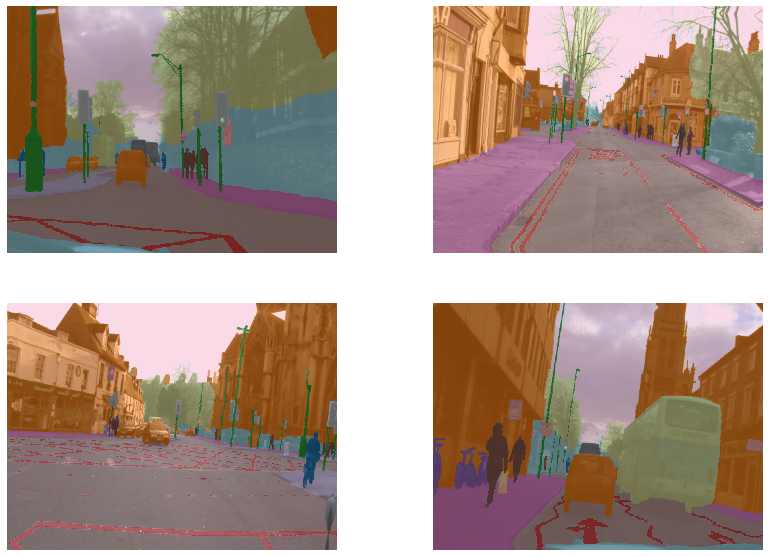

In [18]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [19]:
dls.vocab = codes

In [20]:
name2id = {v:k for k,v in enumerate(codes)}

In [21]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [22]:
void_code = name2id['Void']

In [23]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [24]:
opt = ranger

In [25]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

In [26]:
learn.summary()

DynamicUnet (Input shape: 4 x 3 x 360 x 480)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 90 x 120   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.00015848931798245758)

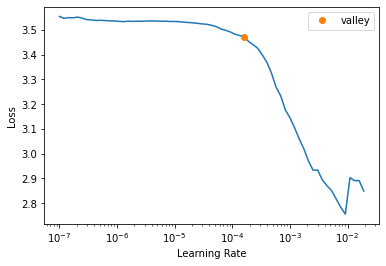

In [27]:
learn.lr_find()

In [28]:
lr = 1e-3

In [29]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.837745,0.529474,0.851999,00:39
1,0.579060,0.415053,0.881073,00:40
2,0.496712,0.364135,0.885379,00:40
3,0.461667,0.323536,0.911639,00:40
4,0.423647,0.367651,0.895807,00:40
5,0.391524,0.299360,0.916292,00:40
6,0.341730,0.300784,0.911072,00:41
7,0.326002,0.257394,0.927326,00:41
8,0.285982,0.265680,0.923301,00:41
9,0.241124,0.259173,0.925134,00:41


In [30]:
learn.save('stage-1')
learn.load('stage-1');

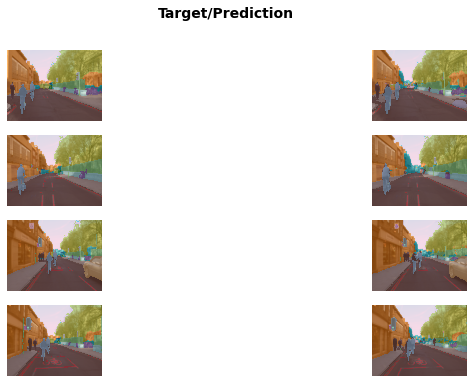

In [31]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [32]:
lrs = slice(lr/400, lr/4)

In [33]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [34]:
learn.unfreeze()

In [35]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.239071,0.246816,0.929967,00:41
1,0.237659,0.263151,0.925424,00:42
2,0.236694,0.257036,0.926506,00:42
3,0.218950,0.254505,0.928671,00:42
4,0.222978,0.248841,0.928201,00:42
5,0.208288,0.269427,0.923805,00:43
6,0.206620,0.282103,0.921828,00:43
7,0.197837,0.270172,0.924887,00:43
8,0.191433,0.270953,0.926177,00:43
9,0.191581,0.256839,0.927412,00:43


In [36]:
learn.save('model_1')

Path('models/model_1.pth')

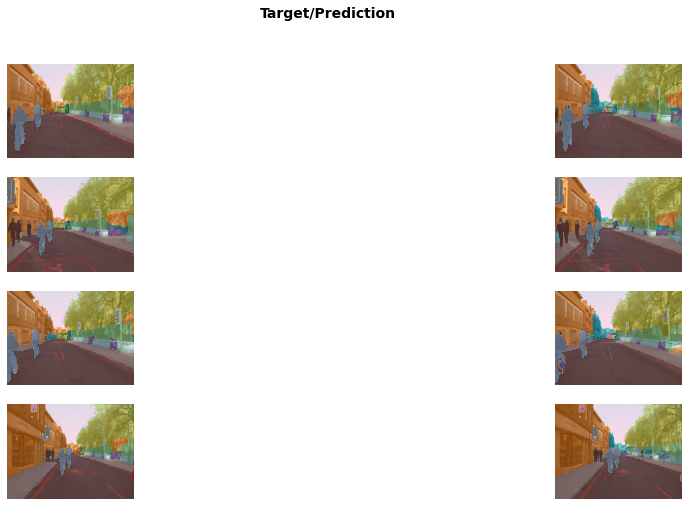

In [37]:
learn.show_results(max_n=4, figsize=(18,8))

## Prediction

In [38]:
dl = learn.dls.test_dl(fnames[:5])

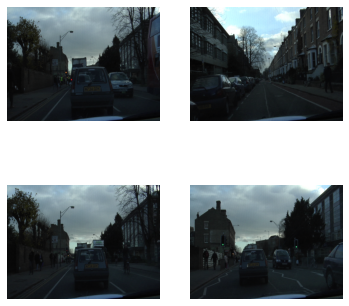

In [39]:
dl.show_batch()

In [40]:
preds = learn.get_preds(dl=dl)

In [41]:
preds[0].shape

torch.Size([5, 32, 360, 480])

In [42]:
len(codes)

32

In [43]:
pred_1 = preds[0][0]

In [44]:
pred_1.shape

torch.Size([32, 360, 480])

In [45]:
pred_arx = pred_1.argmax(dim=0)

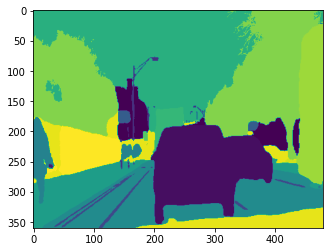

In [46]:
plt.imshow(pred_arx)

In [47]:
pred_arx = pred_arx.numpy()

In [48]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [49]:
im = Image.fromarray(rescaled)

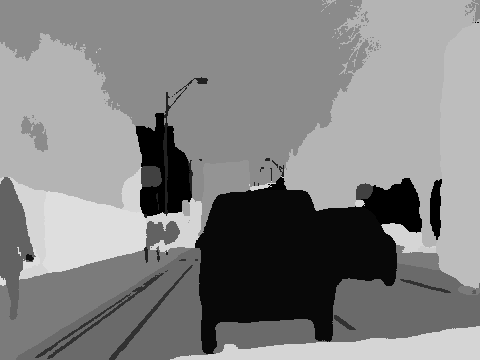

In [50]:
im

In [51]:
im.save('test.png')

In [52]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

In [53]:
torch.save(preds[0][0], 'Image_1.pt')

In [54]:
pred_1 = torch.load('Image_1.pt')

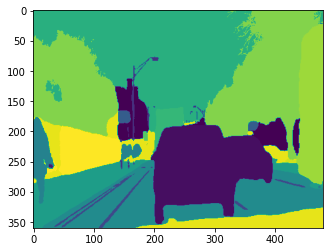

In [55]:
plt.imshow(pred_1.argmax(dim=0))